In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path


from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *


import bokeh
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
from auctions.webutils import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# experiment = Experiment.objects.get(name='april11_flattest_large_2')
experiment = Experiment.objects.get(name='sats_games_5')
experiment

<Experiment: sats_games_5>

In [37]:
master_df = get_all_frames(experiment, expected_additional_br=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.28it/s]


In [38]:
len(master_df)

54

In [39]:
# !ls /shared/outputs

In [40]:
plot_all_models(master_df, notebook=True, final_compare=True)

Loading BokehJS ...

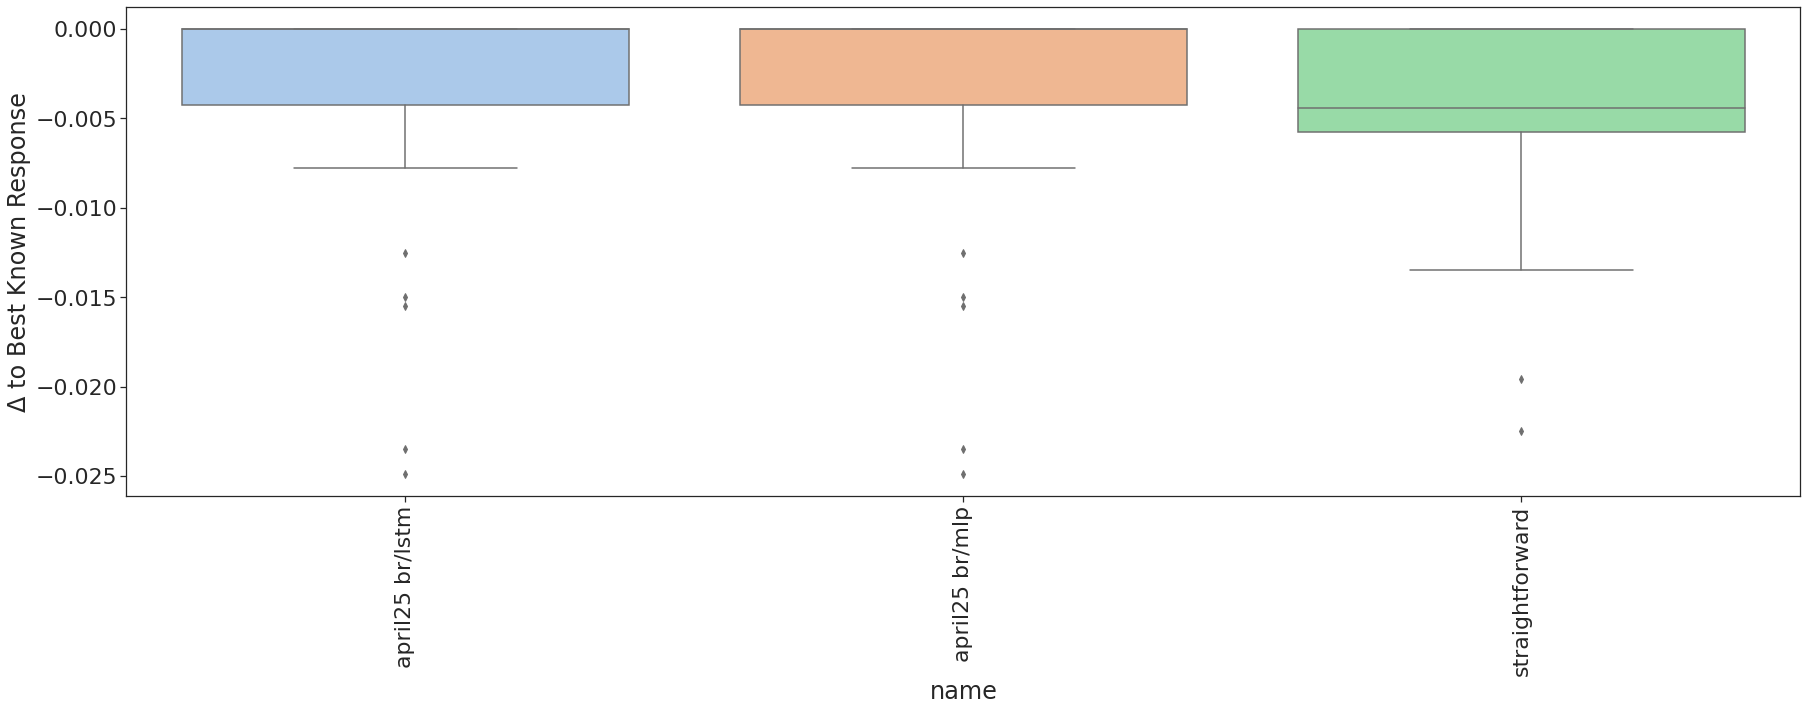

In [17]:
# s = ['_mlp', '_mlp_1', '_mlp_2', '_lstm', '_lstm_1', '_lstm_2', 'Straightforward']
# good_configs = ['straightforward', 'mar17/lstm', 'mar17/mlp-Copy6']
# fig = compare_best_responses(master_df.query('name in @good_configs'))
fig = compare_best_responses(master_df)
# special_save_fig(fig, "configs.png", fmt=None, dpi=300, tight=True)

In [ ]:
master_df.query('t == 10000000 and model == "large_game_2-flatmlpflat_handcrafted_reversed-100" and player == 1')

In [ ]:
master_df

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 5))
# plt.imshow(list(q_network.output_layer.parameters())[0].data)
# plt.colorbar()

In [ ]:
master_df[['name', 'PositiveRegret']]

In [ ]:
x = master_df['name'].unique().tolist()
x.remove(None)
x.remove("straightforward")
x

In [ ]:
for config in x:
    portfolio = [config, 'straightforward']
    p = master_df.query('name in @portfolio and player == br_player').copy()
    # NOT QUITE RIGHT
    p['frac'] = p['PositiveRegret'] / p['MaxPositiveRegret']
    p = p.groupby(['model', 't', 'player']).apply(lambda x: x['frac'].max())
    print(config, p.mean())

In [ ]:
y = list(x)
y.remove('mar17/lstm')
for config in y:
    portfolio = [config, 'mar17/lstm', 'straightforward']
    p = master_df.query('name in @portfolio and player == br_player').copy()
    # NOT QUITE RIGHT
    p['frac'] = p['PositiveRegret'] / p['MaxPositiveRegret']
    p = p.groupby(['model', 't', 'player']).apply(lambda x: x['frac'].max())
    print(config, p.mean())

In [ ]:
z = list(y)
z.remove('_mlp_deep_wide')
for config in z:
    portfolio = [config, '_mlp_deep_wide', '_mlp_wide', 'Straightforward']
    p = master_df.query('config in @portfolio and player == best_responder').copy()
    # NOT QUITE RIGHT
    p['frac'] = p['PositiveRegret'] / p['MaxPositiveRegret']
    p = p.groupby(['model', 't', 'player']).apply(lambda x: x['frac'].max())
    print(config, p.mean())

In [ ]:
dir(bokeh.plotting)

In [ ]:
EquilibriumSolverRun.objects.last().pk

In [ ]:
for run in experiment.equilibriumsolverrun_set.all():
    print(run, run.walltime())

In [ ]:
121496.56349015236